# Задание 2.1 - Нейронные сети

В этом задании вы реализуете и натренируете настоящую нейроную сеть своими руками!

В некотором смысле это будет расширением прошлого задания - нам нужно просто составить несколько линейных классификаторов вместе!

<img src="https://i.redd.it/n9fgba8b0qr01.png" alt="Stack_more_layers" width="400px"/>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_layer_gradient, check_layer_param_gradient, check_model_gradient
from layers import FullyConnectedLayer, ReLULayer
from model import TwoLayerNet
from trainer import Trainer, Dataset
from optim import SGD, MomentumSGD
from metrics import multiclass_accuracy

# Загружаем данные

И разделяем их на training и validation.

In [3]:
def prepare_for_neural_network(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    return train_flat, test_flat
    
train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000)    
train_X, test_X = prepare_for_neural_network(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

# Как всегда, начинаем с кирпичиков

Мы будем реализовывать необходимые нам слои по очереди. Каждый слой должен реализовать:
- прямой проход (forward pass), который генерирует выход слоя по входу и запоминает необходимые данные
- обратный проход (backward pass), который получает градиент по выходу слоя и вычисляет градиент по входу и по параметрам

Начнем с ReLU, у которого параметров нет.

In [4]:
# TODO: Implement ReLULayer layer in layers.py
# Note: you'll need to copy implementation of the gradient_check function from the previous assignment

X = np.array([[1,-2,3],
              [-1, 2, 0.1]
              ])

assert check_layer_gradient(ReLULayer(), X, verbose=0)

Gradient check passed!


А теперь реализуем полносвязный слой (fully connected layer), у которого будет два массива параметров: W (weights) и B (bias).

Все параметры наши слои будут использовать для параметров специальный класс `Param`, в котором будут храниться значения параметров и градиенты этих параметров, вычисляемые во время обратного прохода.

Это даст возможность аккумулировать (суммировать) градиенты из разных частей функции потерь, например, из cross-entropy loss и regularization loss.

In [5]:
# TODO: Implement FullyConnected layer forward and backward methods
assert check_layer_gradient(FullyConnectedLayer(3, 4), X)
# TODO: Implement storing gradients for W and B
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'W')
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'B')

Gradient check passed!
Gradient check passed!
Gradient check passed!


## Создаем нейронную сеть

Теперь мы реализуем простейшую нейронную сеть с двумя полносвязным слоями и нелинейностью ReLU. Реализуйте функцию `compute_loss_and_gradients`, она должна запустить прямой и обратный проход через оба слоя для вычисления градиентов.

Не забудьте реализовать очистку градиентов в начале функции.

In [12]:
# TODO: In model.py, implement compute_loss_and_gradients function
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 0)
loss = model.compute_loss_and_gradients(train_X[:2], train_y[:2])

# TODO Now implement backward pass and aggregate all of the params
check_model_gradient(model, train_X[:2], train_y[:2], tol=1)

Checking gradient for FC0_w
Gradient check passed!
Checking gradient for FC0_b
Gradient check passed!
Checking gradient for FC2_w
Gradient check passed!
Checking gradient for FC2_b
Gradient check passed!


True

Теперь добавьте к модели регуляризацию - она должна прибавляться к loss и делать свой вклад в градиенты.

In [47]:
# TODO Now implement l2 regularization in the forward and backward pass
model_with_reg = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 1e1)
loss_with_reg = model_with_reg.compute_loss_and_gradients(train_X[:2], train_y[:2])
assert loss_with_reg > loss and not np.isclose(loss_with_reg, loss), \
    "Loss with regularization (%2.4f) should be higher than without it (%2.4f)!" % (loss_with_reg, loss)
print('loss:', loss)
print('loss with reg:', loss_with_reg)

check_model_gradient(model_with_reg, train_X[:2], train_y[:2])

loss: 2.3029004697376942
loss with reg: 2.3973803449551423
Checking gradient for FC0_w
Gradient check passed!
Checking gradient for FC0_b
Gradient check passed!
Checking gradient for FC2_w
Gradient check passed!
Checking gradient for FC2_b
Gradient check passed!


True

Также реализуем функцию предсказания (вычисления значения) модели на новых данных.

Какое значение точности мы ожидаем увидеть до начала тренировки?

In [48]:
# Finally, implement predict function!

# TODO: Implement predict function
# What would be the value we expect?
multiclass_accuracy(model_with_reg.predict(train_X[:30]), train_y[:30]) 

0.1

# Допишем код для процесса тренировки

Если все реализовано корректно, значение функции ошибки должно уменьшаться с каждой эпохой, пусть и медленно. Не беспокойтесь пока про validation accuracy.

In [125]:
model = TwoLayerNet(n_input = train_X.shape[1], n_output=10, hidden_layer_size=100, reg=1e-6)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate=1e-2)

# TODO Implement missing pieces in Trainer.fit function
# You should expect loss to go down every epoch, even if it's slow
loss_history, train_history, val_history = trainer.fit()

Epoch 0, Loss: 1023.647252, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch 1, Loss: 1009.690136, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch 2, Loss: 1004.566588, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch 3, Loss: 1002.592345, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch 4, Loss: 1001.428837, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch 5, Loss: 999.503796, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch 6, Loss: 994.617974, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch 7, Loss: 984.942339, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch 8, Loss: 971.917206, Train accuracy: 0.206222, val accuracy: 0.212000
Epoch 9, Loss: 958.202508, Train accuracy: 0.234000, val accuracy: 0.237000
Epoch 10, Loss: 943.907086, Train accuracy: 0.258778, val accuracy: 0.260000
Epoch 11, Loss: 927.493135, Train accuracy: 0.272222, val accuracy: 0.271000
Epoch 12, Loss: 906.772557, Train accuracy: 0.286667, val accuracy: 0.289000
Epoc

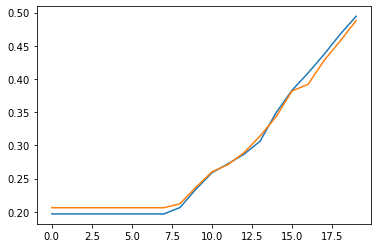

In [126]:
plt.plot(train_history)
plt.plot(val_history)

# Улучшаем процесс тренировки

Мы реализуем несколько ключевых оптимизаций, необходимых для тренировки современных нейросетей.

## Уменьшение скорости обучения (learning rate decay)

Одна из необходимых оптимизаций во время тренировки нейронных сетей - постепенное уменьшение скорости обучения по мере тренировки.

Один из стандартных методов - уменьшение скорости обучения (learning rate) каждые N эпох на коэффициент d (часто называемый decay). Значения N и d, как всегда, являются гиперпараметрами и должны подбираться на основе эффективности на проверочных данных (validation data). 

В нашем случае N будет равным 1.

In [127]:
# TODO Implement learning rate decay inside Trainer.fit method
# Decay should happen once per epoch

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-3)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate_decay=0.99)

initial_learning_rate = trainer.learning_rate
loss_history, train_history, val_history = trainer.fit()

assert trainer.learning_rate < initial_learning_rate, "Learning rate should've been reduced"
assert trainer.learning_rate > 0.5*initial_learning_rate, "Learning rate shouldn'tve been reduced that much!"

Epoch 0, Loss: 1023.758117, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch 1, Loss: 1010.009520, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch 2, Loss: 1005.003458, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch 3, Loss: 1003.140895, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch 4, Loss: 1002.066056, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch 5, Loss: 1000.524121, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch 6, Loss: 996.857372, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch 7, Loss: 988.905928, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch 8, Loss: 977.702252, Train accuracy: 0.197111, val accuracy: 0.207000
Epoch 9, Loss: 965.464759, Train accuracy: 0.221444, val accuracy: 0.228000
Epoch 10, Loss: 952.710155, Train accuracy: 0.247111, val accuracy: 0.244000
Epoch 11, Loss: 938.687490, Train accuracy: 0.261667, val accuracy: 0.268000
Epoch 12, Loss: 921.735305, Train accuracy: 0.281556, val accuracy: 0.283000
Epo

# Накопление импульса (Momentum SGD)

Другой большой класс оптимизаций - использование более эффективных методов градиентного спуска. Мы реализуем один из них - накопление импульса (Momentum SGD).

Этот метод хранит скорость движения, использует градиент для ее изменения на каждом шаге, и изменяет веса пропорционально значению скорости.
(Физическая аналогия: Вместо скорости градиенты теперь будут задавать ускорение, но будет присутствовать сила трения.)

```
velocity = momentum * velocity - learning_rate * gradient 
w = w + velocity
```

`momentum` здесь коэффициент затухания, который тоже является гиперпараметром (к счастью, для него часто есть хорошее значение по умолчанию, типичный диапазон -- 0.8-0.99).

Несколько полезных ссылок, где метод разбирается более подробно:  
http://cs231n.github.io/neural-networks-3/#sgd  
https://distill.pub/2017/momentum/

In [124]:
# TODO: Implement MomentumSGD.update function in optim.py

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-3)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, MomentumSGD(), learning_rate=1e-2, learning_rate_decay=0.99)

# You should see even better results than before!
loss_history, train_history, val_history = trainer.fit()

Epoch 0, Loss: 1002.057709, Train accuracy: 0.222333, val accuracy: 0.220000
Epoch 1, Loss: 902.977935, Train accuracy: 0.368889, val accuracy: 0.378000
Epoch 2, Loss: 733.038857, Train accuracy: 0.553889, val accuracy: 0.561000
Epoch 3, Loss: 630.200936, Train accuracy: 0.622444, val accuracy: 0.609000
Epoch 4, Loss: 583.061951, Train accuracy: 0.631333, val accuracy: 0.598000
Epoch 5, Loss: 548.237917, Train accuracy: 0.699667, val accuracy: 0.679000
Epoch 6, Loss: 526.782356, Train accuracy: 0.711778, val accuracy: 0.691000
Epoch 7, Loss: 509.167051, Train accuracy: 0.730222, val accuracy: 0.695000
Epoch 8, Loss: 499.740208, Train accuracy: 0.740556, val accuracy: 0.681000
Epoch 9, Loss: 488.752688, Train accuracy: 0.693333, val accuracy: 0.658000
Epoch 10, Loss: 483.313262, Train accuracy: 0.723444, val accuracy: 0.671000
Epoch 11, Loss: 470.431527, Train accuracy: 0.766222, val accuracy: 0.731000
Epoch 12, Loss: 465.566115, Train accuracy: 0.785778, val accuracy: 0.714000
Epoch 13

# Ну что, давайте уже тренировать сеть!

## Последний тест - переобучимся (overfit) на маленьком наборе данных

Хороший способ проверить, все ли реализовано корректно - переобучить сеть на маленьком наборе данных.  
Наша модель обладает достаточной мощностью, чтобы приблизить маленький набор данных идеально, поэтому мы ожидаем, что на нем мы быстро дойдем до 100% точности на тренировочном наборе. 

Если этого не происходит, то где-то была допущена ошибка!

In [136]:
data_size = 15
model = TwoLayerNet(n_input = train_X.shape[1], n_output=10, hidden_layer_size=100, reg=1e-6)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
trainer = Trainer(model, dataset, SGD(), learning_rate=1e-1, num_epochs=150, batch_size=5)

# You should expect this to reach 1.0 training accuracy 
loss_history, train_history, val_history = trainer.fit()

Epoch 0, Loss: 6.922030, Train accuracy: 0.200000, val accuracy: 0.133333
Epoch 1, Loss: 6.885024, Train accuracy: 0.200000, val accuracy: 0.133333
Epoch 2, Loss: 6.853204, Train accuracy: 0.200000, val accuracy: 0.133333
Epoch 3, Loss: 6.822285, Train accuracy: 0.200000, val accuracy: 0.133333
Epoch 4, Loss: 6.789129, Train accuracy: 0.200000, val accuracy: 0.133333
Epoch 5, Loss: 6.772747, Train accuracy: 0.200000, val accuracy: 0.133333
Epoch 6, Loss: 6.684365, Train accuracy: 0.200000, val accuracy: 0.066667
Epoch 7, Loss: 6.587616, Train accuracy: 0.266667, val accuracy: 0.000000
Epoch 8, Loss: 6.416364, Train accuracy: 0.400000, val accuracy: 0.000000
Epoch 9, Loss: 6.195040, Train accuracy: 0.400000, val accuracy: 0.000000
Epoch 10, Loss: 5.798013, Train accuracy: 0.400000, val accuracy: 0.000000
Epoch 11, Loss: 5.435054, Train accuracy: 0.400000, val accuracy: 0.000000
Epoch 12, Loss: 5.289647, Train accuracy: 0.400000, val accuracy: 0.000000
Epoch 13, Loss: 5.008235, Train acc

Теперь найдем гипепараметры, для которых этот процесс сходится быстрее.
Если все реализовано корректно, то существуют параметры, при которых процесс сходится в **20** эпох или еще быстрее.
Найдите их!

In [152]:
# Now, tweak some hyper parameters and make it train to 1.0 accuracy in 20 epochs or less

model = TwoLayerNet(n_input = train_X.shape[1], n_output=10, hidden_layer_size=3000, reg=1e-6)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
# TODO: Change any hyperparamers or optimizators to reach training accuracy in 20 epochs
trainer = Trainer(model, dataset, SGD(), learning_rate=2e-1, num_epochs=20, batch_size=5)

loss_history, train_history, val_history = trainer.fit()

Epoch 0, Loss: 6.916773, Train accuracy: 0.266667, val accuracy: 0.066667
Epoch 1, Loss: 6.794463, Train accuracy: 0.400000, val accuracy: 0.000000
Epoch 2, Loss: 6.626846, Train accuracy: 0.400000, val accuracy: 0.000000
Epoch 3, Loss: 6.004165, Train accuracy: 0.333333, val accuracy: 0.000000
Epoch 4, Loss: 5.393123, Train accuracy: 0.333333, val accuracy: 0.000000
Epoch 5, Loss: 5.184641, Train accuracy: 0.533333, val accuracy: 0.133333
Epoch 6, Loss: 4.924417, Train accuracy: 0.533333, val accuracy: 0.000000
Epoch 7, Loss: 4.465237, Train accuracy: 0.600000, val accuracy: 0.000000
Epoch 8, Loss: 4.042994, Train accuracy: 0.666667, val accuracy: 0.000000
Epoch 9, Loss: 3.495173, Train accuracy: 0.800000, val accuracy: 0.133333
Epoch 10, Loss: 3.330471, Train accuracy: 0.800000, val accuracy: 0.133333
Epoch 11, Loss: 2.826936, Train accuracy: 0.600000, val accuracy: 0.000000
Epoch 12, Loss: 2.771648, Train accuracy: 0.933333, val accuracy: 0.066667
Epoch 13, Loss: 1.972838, Train acc

# Итак, основное мероприятие!

Натренируйте лучшую нейросеть! Можно добавлять и изменять параметры, менять количество нейронов в слоях сети и как угодно экспериментировать. 

Добейтесь точности лучше **60%** на validation set.

In [157]:
# TODO: Implement MomentumSGD.update function in optim.py

model = TwoLayerNet(n_input = train_X.shape[1], n_output=10, hidden_layer_size=100, reg=1e-3)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, MomentumSGD(), learning_rate=1e-2, learning_rate_decay=0.99)

# You should see even better results than before!
loss_history, train_history, val_history = trainer.fit()

Epoch 0, Loss: 1003.589125, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch 1, Loss: 895.023949, Train accuracy: 0.412667, val accuracy: 0.417000
Epoch 2, Loss: 742.132612, Train accuracy: 0.528000, val accuracy: 0.525000
Epoch 3, Loss: 641.712801, Train accuracy: 0.618778, val accuracy: 0.610000
Epoch 4, Loss: 574.758389, Train accuracy: 0.669222, val accuracy: 0.652000
Epoch 5, Loss: 540.943640, Train accuracy: 0.693667, val accuracy: 0.663000
Epoch 6, Loss: 522.125657, Train accuracy: 0.711556, val accuracy: 0.680000
Epoch 7, Loss: 507.918903, Train accuracy: 0.715889, val accuracy: 0.689000
Epoch 8, Loss: 495.375572, Train accuracy: 0.730222, val accuracy: 0.688000
Epoch 9, Loss: 493.041882, Train accuracy: 0.736778, val accuracy: 0.693000
Epoch 10, Loss: 482.871046, Train accuracy: 0.734778, val accuracy: 0.680000
Epoch 11, Loss: 465.620891, Train accuracy: 0.768667, val accuracy: 0.708000
Epoch 12, Loss: 467.265816, Train accuracy: 0.787778, val accuracy: 0.708000
Epoch 13

In [158]:
loss_history, train_history, val_history = trainer.fit()

Epoch 0, Loss: 431.032714, Train accuracy: 0.795111, val accuracy: 0.712000
Epoch 1, Loss: 425.624675, Train accuracy: 0.837111, val accuracy: 0.746000
Epoch 2, Loss: 417.579734, Train accuracy: 0.823222, val accuracy: 0.732000
Epoch 3, Loss: 418.762394, Train accuracy: 0.843778, val accuracy: 0.747000
Epoch 4, Loss: 408.402553, Train accuracy: 0.845000, val accuracy: 0.749000
Epoch 5, Loss: 405.230266, Train accuracy: 0.805333, val accuracy: 0.718000
Epoch 6, Loss: 405.697530, Train accuracy: 0.838556, val accuracy: 0.745000
Epoch 7, Loss: 402.755472, Train accuracy: 0.861222, val accuracy: 0.773000
Epoch 8, Loss: 401.729564, Train accuracy: 0.854556, val accuracy: 0.740000
Epoch 9, Loss: 404.291424, Train accuracy: 0.836667, val accuracy: 0.747000
Epoch 10, Loss: 399.781372, Train accuracy: 0.853889, val accuracy: 0.753000
Epoch 11, Loss: 395.213920, Train accuracy: 0.862889, val accuracy: 0.758000
Epoch 12, Loss: 396.041692, Train accuracy: 0.851222, val accuracy: 0.740000
Epoch 13,

In [159]:
trainer.learning_rate

0.006689717585696805

In [161]:
trainer.learning_rate = 1e-2
loss_history, train_history, val_history = trainer.fit()

Epoch 0, Loss: 437.807245, Train accuracy: 0.828222, val accuracy: 0.728000
Epoch 1, Loss: 433.344374, Train accuracy: 0.855889, val accuracy: 0.748000
Epoch 2, Loss: 429.870111, Train accuracy: 0.834222, val accuracy: 0.743000
Epoch 3, Loss: 423.082695, Train accuracy: 0.845556, val accuracy: 0.735000
Epoch 4, Loss: 423.881662, Train accuracy: 0.829889, val accuracy: 0.729000
Epoch 5, Loss: 421.887134, Train accuracy: 0.819111, val accuracy: 0.703000
Epoch 6, Loss: 420.720048, Train accuracy: 0.845778, val accuracy: 0.731000
Epoch 7, Loss: 420.946262, Train accuracy: 0.847667, val accuracy: 0.732000
Epoch 8, Loss: 409.537437, Train accuracy: 0.848333, val accuracy: 0.735000
Epoch 9, Loss: 423.322232, Train accuracy: 0.849222, val accuracy: 0.742000
Epoch 10, Loss: 410.483562, Train accuracy: 0.848667, val accuracy: 0.743000
Epoch 11, Loss: 410.507871, Train accuracy: 0.874889, val accuracy: 0.764000
Epoch 12, Loss: 405.663441, Train accuracy: 0.879444, val accuracy: 0.758000
Epoch 13,

In [162]:
trainer.learning_rate

0.008179069375972308

In [163]:
loss_history, train_history, val_history = trainer.fit()

Epoch 0, Loss: 395.706992, Train accuracy: 0.863222, val accuracy: 0.748000
Epoch 1, Loss: 396.298364, Train accuracy: 0.859000, val accuracy: 0.727000
Epoch 2, Loss: 395.203586, Train accuracy: 0.840111, val accuracy: 0.727000
Epoch 3, Loss: 394.665493, Train accuracy: 0.818667, val accuracy: 0.714000
Epoch 4, Loss: 395.290294, Train accuracy: 0.867222, val accuracy: 0.746000
Epoch 5, Loss: 391.220166, Train accuracy: 0.885333, val accuracy: 0.767000
Epoch 6, Loss: 386.589752, Train accuracy: 0.858000, val accuracy: 0.734000
Epoch 7, Loss: 384.852209, Train accuracy: 0.893333, val accuracy: 0.770000
Epoch 8, Loss: 384.611889, Train accuracy: 0.890556, val accuracy: 0.779000
Epoch 9, Loss: 386.445803, Train accuracy: 0.894111, val accuracy: 0.762000
Epoch 10, Loss: 380.923465, Train accuracy: 0.885667, val accuracy: 0.756000
Epoch 11, Loss: 378.854580, Train accuracy: 0.874333, val accuracy: 0.766000
Epoch 12, Loss: 386.292863, Train accuracy: 0.879000, val accuracy: 0.767000
Epoch 13,

In [164]:
trainer.learning_rate /= 10
loss_history, train_history, val_history = trainer.fit()

Epoch 0, Loss: 329.432646, Train accuracy: 0.935889, val accuracy: 0.787000
Epoch 1, Loss: 315.598040, Train accuracy: 0.939222, val accuracy: 0.793000
Epoch 2, Loss: 313.334157, Train accuracy: 0.938556, val accuracy: 0.800000
Epoch 3, Loss: 312.167521, Train accuracy: 0.939778, val accuracy: 0.794000
Epoch 4, Loss: 311.370503, Train accuracy: 0.943000, val accuracy: 0.798000
Epoch 5, Loss: 310.652883, Train accuracy: 0.942333, val accuracy: 0.801000
Epoch 6, Loss: 309.617698, Train accuracy: 0.939778, val accuracy: 0.793000
Epoch 7, Loss: 309.139949, Train accuracy: 0.942889, val accuracy: 0.796000
Epoch 8, Loss: 309.242936, Train accuracy: 0.942778, val accuracy: 0.802000
Epoch 9, Loss: 308.300996, Train accuracy: 0.944667, val accuracy: 0.799000
Epoch 10, Loss: 307.798310, Train accuracy: 0.940000, val accuracy: 0.795000
Epoch 11, Loss: 307.588009, Train accuracy: 0.945556, val accuracy: 0.805000
Epoch 12, Loss: 306.921439, Train accuracy: 0.945000, val accuracy: 0.801000
Epoch 13,

In [165]:
loss_history, train_history, val_history = trainer.fit()

Epoch 0, Loss: 304.427104, Train accuracy: 0.948000, val accuracy: 0.800000
Epoch 1, Loss: 304.301584, Train accuracy: 0.947778, val accuracy: 0.798000
Epoch 2, Loss: 303.973414, Train accuracy: 0.946778, val accuracy: 0.800000
Epoch 3, Loss: 303.534781, Train accuracy: 0.945111, val accuracy: 0.797000
Epoch 4, Loss: 303.581012, Train accuracy: 0.947000, val accuracy: 0.799000
Epoch 5, Loss: 303.242791, Train accuracy: 0.948667, val accuracy: 0.801000
Epoch 6, Loss: 302.925693, Train accuracy: 0.946333, val accuracy: 0.796000
Epoch 7, Loss: 302.835860, Train accuracy: 0.949889, val accuracy: 0.805000
Epoch 8, Loss: 302.505669, Train accuracy: 0.948111, val accuracy: 0.800000
Epoch 9, Loss: 302.168044, Train accuracy: 0.949111, val accuracy: 0.801000
Epoch 10, Loss: 302.167876, Train accuracy: 0.949222, val accuracy: 0.800000
Epoch 11, Loss: 301.808240, Train accuracy: 0.948333, val accuracy: 0.804000
Epoch 12, Loss: 301.750398, Train accuracy: 0.947889, val accuracy: 0.796000
Epoch 13,

In [166]:
trainer.learning_rate

0.00044752321376381087

In [167]:
trainer.learning_rate *= 2
loss_history, train_history, val_history = trainer.fit()

Epoch 0, Loss: 303.431637, Train accuracy: 0.949556, val accuracy: 0.796000
Epoch 1, Loss: 303.272138, Train accuracy: 0.946111, val accuracy: 0.798000
Epoch 2, Loss: 302.405646, Train accuracy: 0.948556, val accuracy: 0.800000
Epoch 3, Loss: 302.349742, Train accuracy: 0.948111, val accuracy: 0.792000
Epoch 4, Loss: 302.128999, Train accuracy: 0.950111, val accuracy: 0.795000
Epoch 5, Loss: 301.963428, Train accuracy: 0.950333, val accuracy: 0.799000
Epoch 6, Loss: 301.412016, Train accuracy: 0.948222, val accuracy: 0.797000
Epoch 7, Loss: 301.812633, Train accuracy: 0.949556, val accuracy: 0.795000
Epoch 8, Loss: 301.163441, Train accuracy: 0.949444, val accuracy: 0.799000
Epoch 9, Loss: 301.007980, Train accuracy: 0.950222, val accuracy: 0.798000
Epoch 10, Loss: 300.688066, Train accuracy: 0.952889, val accuracy: 0.800000
Epoch 11, Loss: 300.586106, Train accuracy: 0.951778, val accuracy: 0.801000
Epoch 12, Loss: 300.510334, Train accuracy: 0.951222, val accuracy: 0.803000
Epoch 13,

In [168]:
trainer.learning_rate /= 10
loss_history, train_history, val_history = trainer.fit()

Epoch 0, Loss: 294.905345, Train accuracy: 0.954111, val accuracy: 0.801000
Epoch 1, Loss: 294.187918, Train accuracy: 0.954889, val accuracy: 0.798000
Epoch 2, Loss: 293.935956, Train accuracy: 0.954556, val accuracy: 0.801000
Epoch 3, Loss: 293.920912, Train accuracy: 0.955444, val accuracy: 0.798000
Epoch 4, Loss: 293.857191, Train accuracy: 0.955333, val accuracy: 0.800000
Epoch 5, Loss: 293.818077, Train accuracy: 0.955667, val accuracy: 0.800000
Epoch 6, Loss: 293.817567, Train accuracy: 0.955333, val accuracy: 0.800000
Epoch 7, Loss: 293.743369, Train accuracy: 0.955222, val accuracy: 0.797000
Epoch 8, Loss: 293.724874, Train accuracy: 0.955778, val accuracy: 0.799000
Epoch 9, Loss: 293.711878, Train accuracy: 0.955222, val accuracy: 0.799000
Epoch 10, Loss: 293.654544, Train accuracy: 0.955333, val accuracy: 0.799000
Epoch 11, Loss: 293.641173, Train accuracy: 0.955556, val accuracy: 0.797000
Epoch 12, Loss: 293.670496, Train accuracy: 0.955444, val accuracy: 0.799000
Epoch 13,

In [169]:
trainer.learning_rate /= 10
loss_history, train_history, val_history = trainer.fit()

Epoch 0, Loss: 293.035429, Train accuracy: 0.956111, val accuracy: 0.797000
Epoch 1, Loss: 293.023264, Train accuracy: 0.956000, val accuracy: 0.797000
Epoch 2, Loss: 293.014285, Train accuracy: 0.956000, val accuracy: 0.797000
Epoch 3, Loss: 293.007220, Train accuracy: 0.955889, val accuracy: 0.798000
Epoch 4, Loss: 293.003991, Train accuracy: 0.956000, val accuracy: 0.799000
Epoch 5, Loss: 293.001057, Train accuracy: 0.956000, val accuracy: 0.800000
Epoch 6, Loss: 292.996881, Train accuracy: 0.955889, val accuracy: 0.800000
Epoch 7, Loss: 292.996955, Train accuracy: 0.955889, val accuracy: 0.800000
Epoch 8, Loss: 292.993453, Train accuracy: 0.955889, val accuracy: 0.800000
Epoch 9, Loss: 292.989740, Train accuracy: 0.955778, val accuracy: 0.800000
Epoch 10, Loss: 292.986937, Train accuracy: 0.955778, val accuracy: 0.800000
Epoch 11, Loss: 292.984249, Train accuracy: 0.955667, val accuracy: 0.800000
Epoch 12, Loss: 292.983740, Train accuracy: 0.955667, val accuracy: 0.800000
Epoch 13,

In [171]:
from metrics import multiclass_accuracy

multiclass_accuracy(trainer.model.predict(test_X), test_y)

0.779